<AxesSubplot:xlabel='year'>

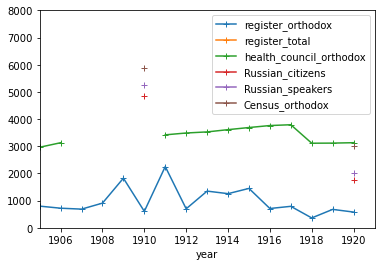

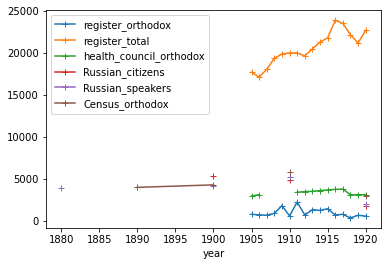

In [14]:
import warnings
from pathlib import Path

import pandas as pd

data_dir = Path('../data')
warnings.simplefilter(action='ignore', category=FutureWarning)

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
institutions = pd.read_csv(data_dir / 'institutions.csv', dtype={'district': str, 'plot_number': str})

districts_in_city = [
    'Valli',
    'Salakkalahti',
    'Repola',
    'Anina',
    'Papula',
    'P_Annan_kruunu',
    'Hiekka',
    'Pantsarlahti',
    'Viipurin_esikaupunki',
    'Paulovski',
    'Havi',
    'Saunalahti',
    'Pietarin_esikaupunki',
]

poll_tax = pd.read_csv(data_dir / 'poll_tax_register.csv', index_col=0)
poll_tax['total'] = poll_tax.total_women + poll_tax.total_men
health_council = pd.read_csv(data_dir / 'health_council.csv', index_col=0).pop_orthodox
foreigners = pd.read_csv(data_dir / 'foreigners.csv', index_col=0).russia
language = pd.read_csv(data_dir / 'language.csv', index_col=0).russian
religion = pd.read_csv(data_dir / 'religion.csv', index_col=0).orthodox
data = pd.DataFrame([poll_tax.orthodox, poll_tax.total, health_council, foreigners, language, religion]).T
data.columns = ['register_orthodox', 'register_total', 'health_council_orthodox', 'Russian_citizens', 'Russian_speakers', 'Census_orthodox']
# data.interpolate(method='linear', inplace=True)
data.plot(marker='+', xlim=(1905, 1921), ylim=(0, 8000))
data.plot(marker='+')

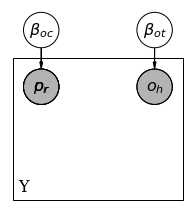

In [17]:
import daft
from matplotlib import rc

rc("font", family="serif", size=16)
scale = 1.25
pgm = daft.PGM()

pgm.add_node('health_orthodox', r'$o_h$', 3, 2, fixed=False, scale=scale, observed=True)
pgm.add_node('register_orthodox', r'$o_r$', 1, 2, fixed=False, scale=scale, observed=True)
pgm.add_node('register_total', r'$p_r$', 1, 2, fixed=False, scale=scale, observed=True)
pgm.add_node('beta_orthodox_city', r'$\beta_{oc}$', 1, 3, fixed=False, scale=scale, observed=False)
pgm.add_node('beta_orthodox_total', r'$\beta_{ot}$', 3, 3, fixed=False, scale=scale, observed=False)

pgm.add_edge('beta_orthodox_city', 'register_orthodox', directed=True)
pgm.add_edge('beta_orthodox_total', 'health_orthodox', directed=True)

pgm.add_plate([0.5, 0, 3, 2.5], 'Y')

pgm.render()

Model:

$ o_t = y_t - m_t $

In [4]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

data = pd.read_csv('data.csv', index_col=0)
data = data.loc[:, 'total orthodox income_per_person'.split()].dropna(axis=0)

with pm.Model() as model:
    mu_S = 0.3
    sigma_S = 0.1
    S = pm.Beta('S', mu=mu_S, sigma=sigma_S)
    mu_W = 2
    lambda_W = 1/mu_W
    W_k = pm.Exponential('W_k', lambda_W, observed=data.income_per_person)
    mu_P = 14
    P_k = pm.Poisson('P_k', mu_P, observed=data.total)
    mu_beta = np.array([0., 0., 0., 0.])
    sigma_beta = np.array(np.diagflat([0.25, 0.25, 0.25, 0.25]))
    beta = pm.MvNormal('beta', mu_beta, sigma_beta, shape=4)
    mu_O = np.exp(beta[0] + beta[1] * W_k + beta[2] * P_k + beta[3] * S)
    alpha_O = 2
    O_k = pm.Poisson('O_k', mu_O, observed=data.orthodox)

    prior = pm.sample_prior_predictive()
    posterior = pm.sample(init="adapt_diag")
    posterior_prediction = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_trace(posterior)
az.plot_forest(posterior, combined=False, hdi_prob=0.94)
pm.model_to_graphviz(model)


ImportError: DLL load failed while importing defs: Määritettyä proseduuria ei löydy.